In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import pyproj
import pygmt
import eqs_magnetics as eqs
import harmonica as hm
import itertools
import xarray as xr
import synthetics
import warnings

In [2]:
# Suppress some scikit-learn warning that isn't valid
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data

In [3]:
icegrav = pd.read_csv('../../data-for-eqs-gb-norm-of-b/icegrav.csv', header=0)
icegrav_synthetic = pd.read_csv('../../data-for-eqs-gb-norm-of-b/icegrav_synthetic.csv', header=0)
icegrav_synthetic_sources = pd.read_csv('../../data-for-eqs-gb-norm-of-b/icegrav_synthetic_sources.csv', header=0)

icegrav_coords = [icegrav.x, icegrav.y, icegrav.Height_WGS1984]
coordinates = [icegrav_synthetic.x, icegrav_synthetic.y, icegrav_synthetic.u]
source_coordinates = [icegrav_synthetic_sources.x, icegrav_synthetic_sources.y, icegrav_synthetic_sources.u]
dipole_moments = [icegrav_synthetic_sources.dipole_moment_x, icegrav_synthetic_sources.dipole_moment_y, icegrav_synthetic_sources.dipole_moment_u]

field_direction = np.array([hm.magnetic_angles_to_vec(1, -65, 25)]).T

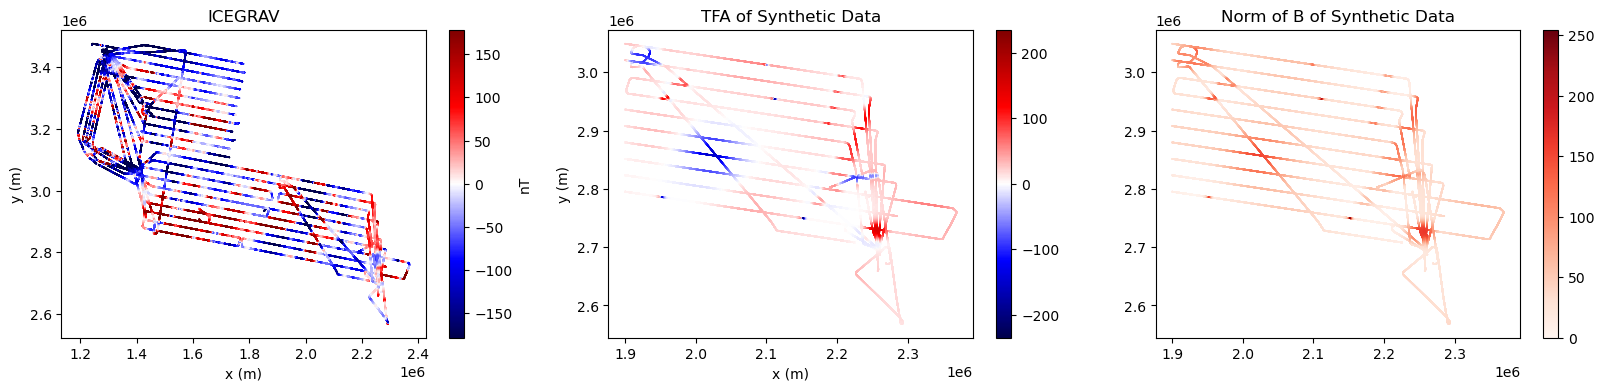

In [4]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
scale = np.nanpercentile(icegrav.MagL, 95)
plt.scatter(*icegrav_coords[:2], c=icegrav.MagL, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("ICEGRAV")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
scale = vd.maxabs(icegrav_synthetic.tfa)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.tfa, cmap="seismic",s=0.01, vmin=-scale, vmax=scale)
plt.title("TFA of Synthetic Data")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.colorbar()
plt.subplot(1,3,3)
scale = vd.maxabs(icegrav_synthetic.bnorm)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.bnorm, cmap="Reds",s=0.01, vmin=0, vmax=scale)
plt.title("Norm of B of Synthetic Data")
plt.colorbar()
plt.show()

In [5]:
grid_spacing = 5e3
grid_coordinates = vd.grid_coordinates(vd.get_region(coordinates), spacing=grid_spacing, extra_coords=3e3)
mask = vd.distance_mask(data_coordinates=coordinates, maxdist=2.8e4, coordinates=grid_coordinates)
# mask = vd.convexhull_mask(coordinates, grid_coordinates)
grid_coords_masked = (
    np.array((xr.DataArray(grid_coordinates[0])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[1])).where(mask, drop=False)),
    np.array((xr.DataArray(grid_coordinates[2])).where(mask, drop=False))
)
true_b = eqs.dipole_magnetic(grid_coords_masked, source_coordinates, dipole_moments)
true_tfa = eqs.total_field_anomaly(true_b, field_direction)
true_bnorm = np.sqrt(sum(c**2 for c in true_b))

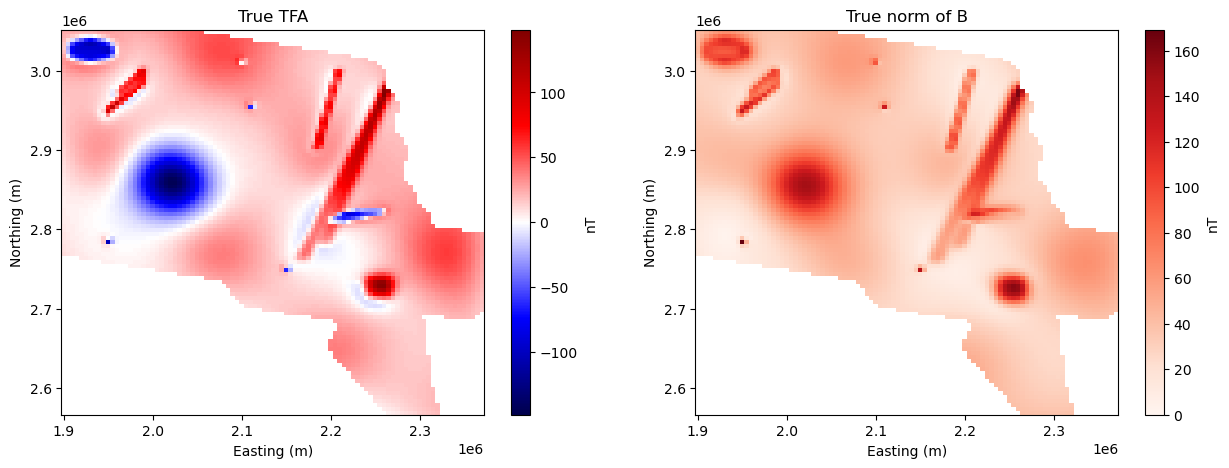

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,2,2)
scale = vd.maxabs(true_bnorm)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## One layer GB EQS

In [7]:
dampings = [1e3, 1e4, 1e5, 1e6]
depths = [40e3, 45e3, 50e3, 55e3, 60e3, 65e3, 70e3]
parameter_sets = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings, depths)
]
print("Number of combinations:", len(parameter_sets))

Number of combinations: 28


In [8]:
%%time
kfold = vd.BlockKFold(
    spacing=5e4,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets:    
    print(parameters)
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=500, **parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            icegrav_synthetic.tfa[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(icegrav_synthetic.tfa[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

{'damping': 1000.0, 'depth': 40000.0}
{'damping': 1000.0, 'depth': 45000.0}
{'damping': 1000.0, 'depth': 50000.0}
{'damping': 1000.0, 'depth': 55000.0}
{'damping': 1000.0, 'depth': 60000.0}
{'damping': 1000.0, 'depth': 65000.0}
{'damping': 1000.0, 'depth': 70000.0}
{'damping': 10000.0, 'depth': 40000.0}
{'damping': 10000.0, 'depth': 45000.0}
{'damping': 10000.0, 'depth': 50000.0}
{'damping': 10000.0, 'depth': 55000.0}
{'damping': 10000.0, 'depth': 60000.0}
{'damping': 10000.0, 'depth': 65000.0}
{'damping': 10000.0, 'depth': 70000.0}
{'damping': 100000.0, 'depth': 40000.0}
{'damping': 100000.0, 'depth': 45000.0}
{'damping': 100000.0, 'depth': 50000.0}
{'damping': 100000.0, 'depth': 55000.0}
{'damping': 100000.0, 'depth': 60000.0}
{'damping': 100000.0, 'depth': 65000.0}
{'damping': 100000.0, 'depth': 70000.0}
{'damping': 1000000.0, 'depth': 40000.0}
{'damping': 1000000.0, 'depth': 45000.0}
{'damping': 1000000.0, 'depth': 50000.0}
{'damping': 1000000.0, 'depth': 55000.0}
{'damping': 10000

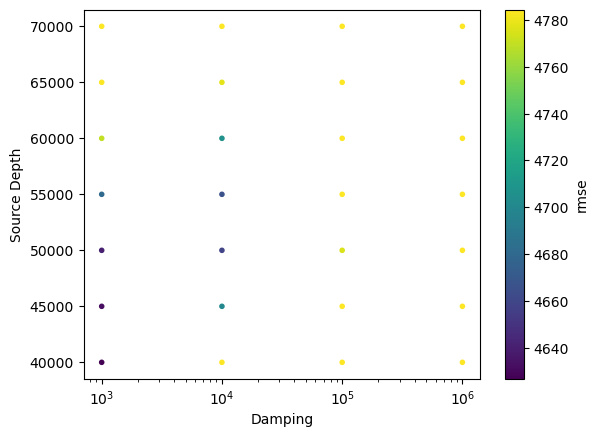

In [9]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,40),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='rmse')
plt.show()

In [10]:
best = np.argmin(scores)
parameter_sets[best]

{'damping': 1000.0, 'depth': 40000.0}

In [11]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(random_state=0, block_size=500, **parameter_sets[best])
eqs_shallow.fit(coordinates, icegrav_synthetic.tfa, field_direction)
print("dipole height:", eqs_shallow.dipole_coordinates_[2][0])
print("window size:", eqs_shallow.window_size_)

dipole height: -37098.05
window size: 98440.82659940823
CPU times: user 5min 20s, sys: 1min 19s, total: 6min 40s
Wall time: 29.3 s


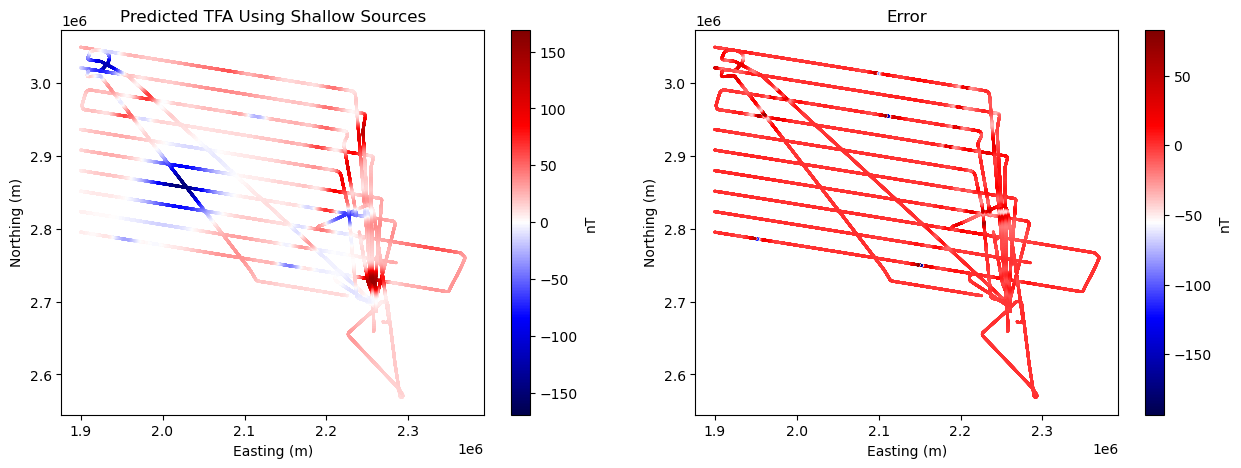

In [12]:
tfa_predicted = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_predicted, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
plt.scatter(*coordinates[:2], c=icegrav_synthetic.tfa - tfa_predicted, cmap="seismic", s=1)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

### Grid Prediction

In [13]:
predicted_b = eqs_shallow.predict(grid_coords_masked)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa

predicted_norm_of_b = np.sqrt(sum(c**2 for c in predicted_b))
error_norm_of_b = true_bnorm - predicted_norm_of_b

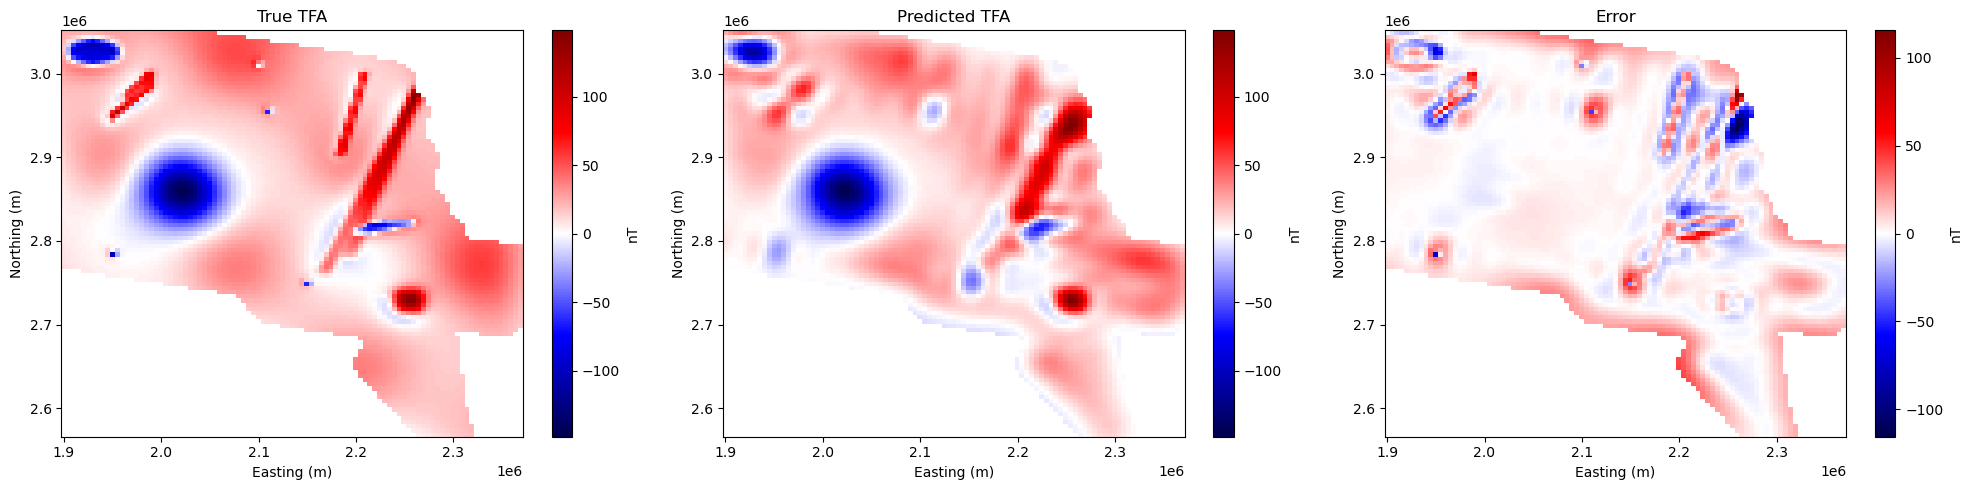

In [14]:
scale_tfa = vd.maxabs(true_tfa)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="seismic", vmin=-scale_tfa, vmax=scale_tfa)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

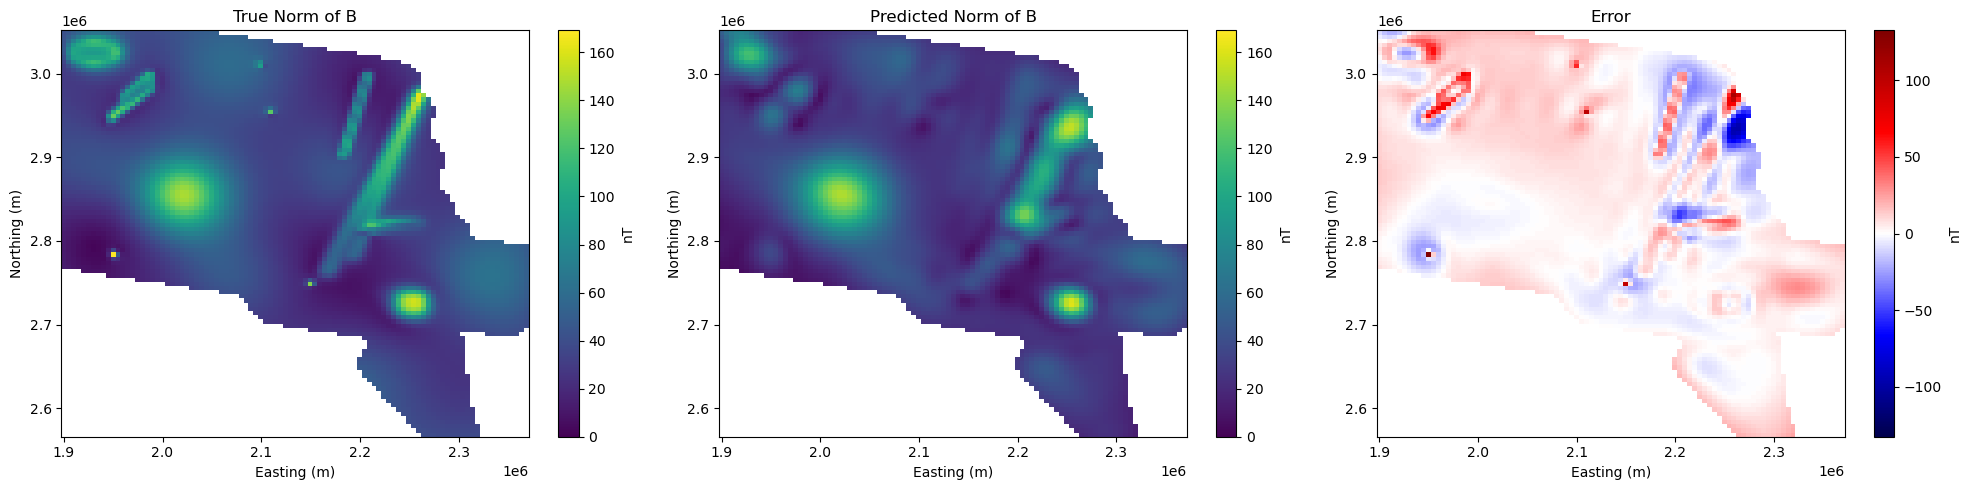

In [15]:
scale_b = vd.maxabs(true_bnorm)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("True Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
plt.pcolormesh(*grid_coordinates[:2], predicted_norm_of_b, cmap="viridis", vmin=0, vmax=scale_b)
plt.title("Predicted Norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
diff_scale = vd.maxabs(error_norm_of_b)
plt.pcolormesh(*grid_coordinates[:2], error_norm_of_b, cmap="seismic", vmin=-diff_scale, vmax=diff_scale)
plt.title("Error")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

## Fit deep sources

### Block average

In [16]:
region = vd.get_region(coordinates)
block_spacing = 10e3#35e3
reducer = vd.BlockReduce(
    reduction=np.median,
    spacing=block_spacing,
    region=(vd.pad_region(region, pad=block_spacing*0.2)),
    drop_coords=False
)
# Use the filter method to apply the reduction:
coords_blocked, tfa_blocked = reducer.filter(coordinates, data=icegrav_synthetic.tfa)

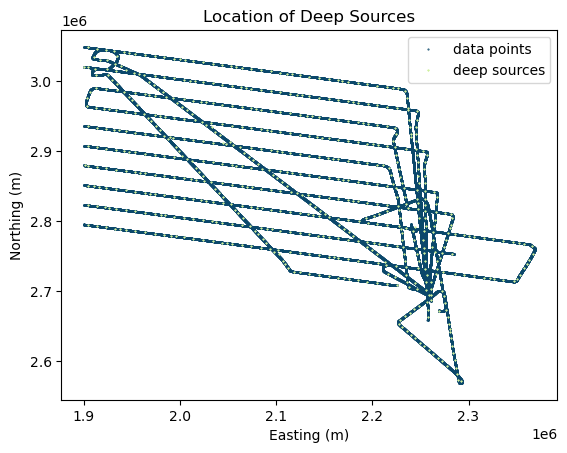

In [17]:
plt.figure()
plt.plot(*coordinates[:2], ".", color="#0B486B", markersize=1, label='data points')
plt.plot(*coords_blocked[:2], "*", color="#cff09e", markersize=1, label='deep sources')
plt.title("Location of Deep Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.legend()
plt.show()

### Find optimal damping and depth

In [18]:
spacing = np.mean(vd.median_distance(coords_blocked))
depths_deep_eqs = [spacing*2.5, spacing*3, spacing*3.5, spacing*4, spacing*4.25, spacing*4.5, spacing*4.75, spacing*5, spacing*5.5, spacing*6]
dampings_deep_eqs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
# depths_deep_eqs = [spacing*3, spacing*3.5, spacing*4]
# dampings_deep_eqs = [1e1, 1e2, 1e3]

In [19]:
parameter_sets_deep_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_deep_eqs, depths_deep_eqs)
]
print("Number of combinations:", len(parameter_sets_deep_eqs))

Number of combinations: 110


In [20]:
%%time
kfold = vd.BlockKFold(
    spacing=5e4,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coords_blocked[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_deep_eqs:    
    # print(parameters)
    eqs_deep = eqs.EquivalentSourcesMagnetic(**parameters)
    tmp = []
    for train, test in kfold.split(features):
        eqs_deep.fit(
            [c[train] for c in coords_blocked], 
            tfa_blocked[train], 
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_deep.predict([c[test] for c in coords_blocked]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_blocked[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])

best_deep = np.argmin(scores)
parameter_sets_deep_eqs[best_deep]

CPU times: user 24min 21s, sys: 10min 54s, total: 35min 15s
Wall time: 59.9 s


{'damping': 1, 'depth': 44972.60749452005}

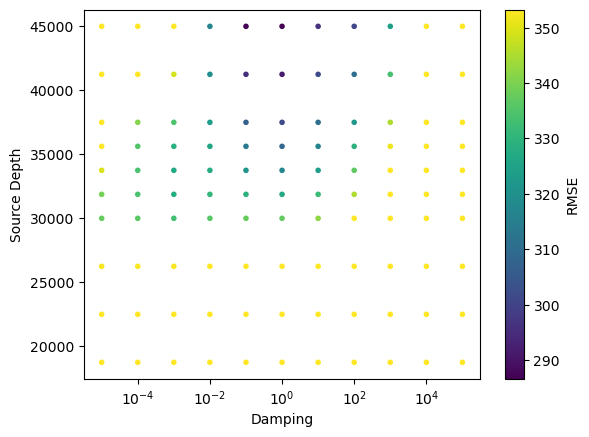

In [21]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,50),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='RMSE')
plt.show()

###  Deep prediction

In [22]:
%%time
eqs_deep = eqs.EquivalentSourcesMagnetic(**parameter_sets_deep_eqs[best_deep])
eqs_deep.fit(coords_blocked, tfa_blocked, field_direction)
print("source height:", eqs_deep.dipole_coordinates_[2][0])

source height: -42079.05749452005
CPU times: user 931 ms, sys: 197 ms, total: 1.13 s
Wall time: 33.1 ms


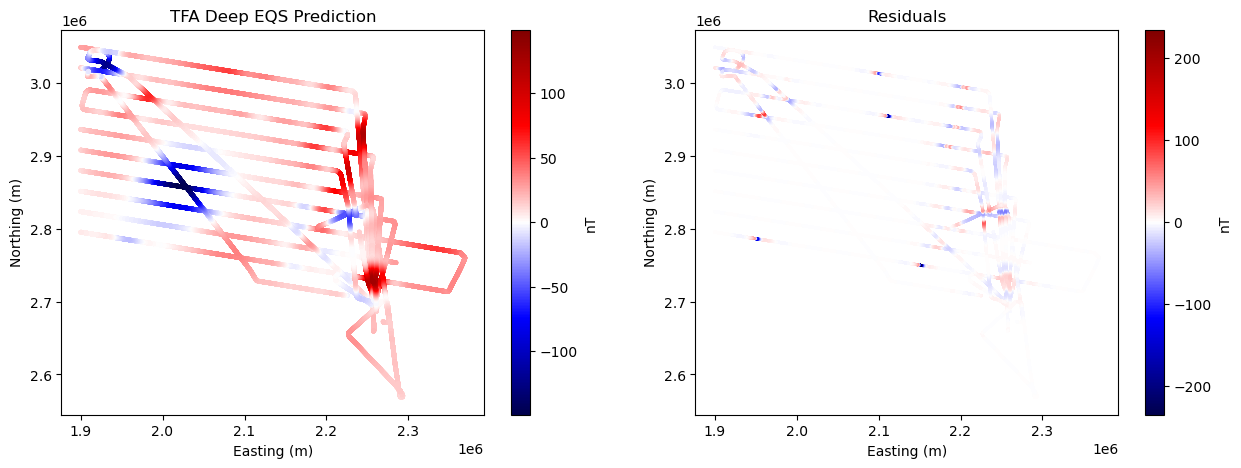

In [23]:
tfa_deep_blocked = eqs.total_field_anomaly(eqs_deep.predict(coords_blocked), field_direction)
tfa_deep = eqs.total_field_anomaly(eqs_deep.predict(coordinates), field_direction)
tfa_residuals = icegrav_synthetic.tfa - tfa_deep

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
scale = vd.maxabs(tfa_deep)
plt.scatter(*coordinates[:2], c=tfa_deep, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals)
plt.scatter(*coordinates[:2], c=tfa_residuals, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

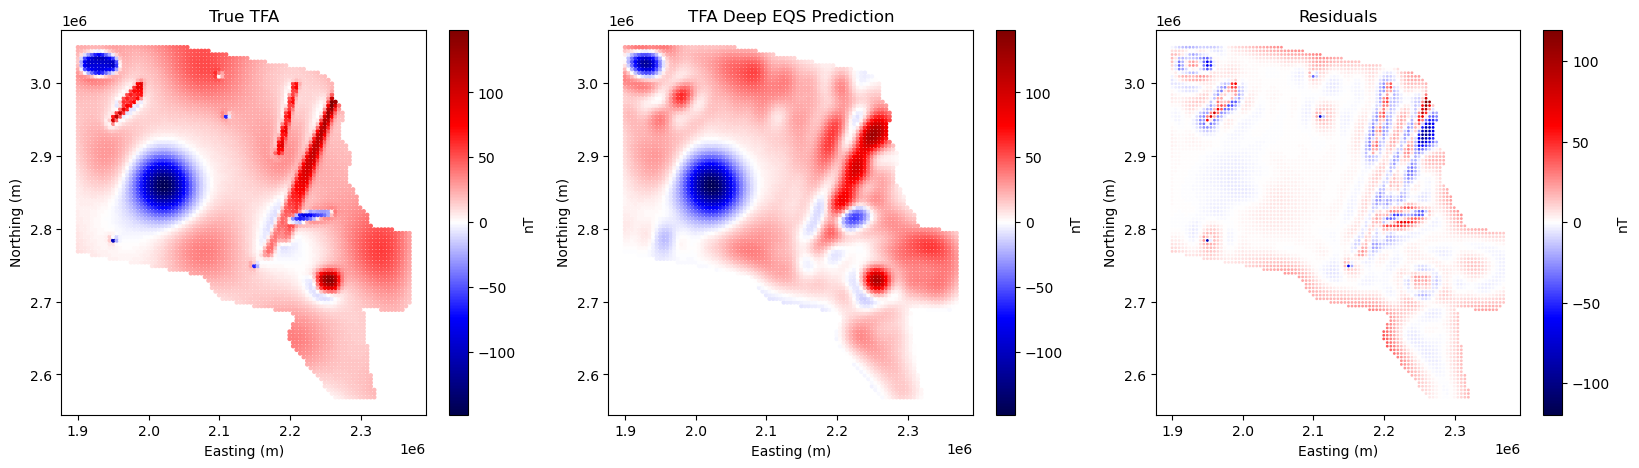

In [24]:
tfa_deep_grid = eqs.total_field_anomaly(eqs_deep.predict(grid_coords_masked), field_direction)
tfa_residuals_grid = true_tfa - tfa_deep_grid
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_tfa)
plt.scatter(*grid_coords_masked[:2], c=true_tfa, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,2)
# scale = vd.maxabs(tfa_deep_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_deep_grid, cmap="seismic", s=5, vmin=-scale, vmax=scale)
plt.title("TFA Deep EQS Prediction")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.subplot(1,3,3)
scale = vd.maxabs(tfa_residuals_grid)
plt.scatter(*grid_coords_masked[:2], c=tfa_residuals_grid, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Residuals")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Fit the deep residuals with gradient-boosted sources

### Find optimal damping and depth

In [25]:
window_size = 2e5
dampings_shallow_eqs = [1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5]
depths_shallow_eqs = [5e3, 6e3, 7e3, 8e3, 9e3, 10e3, 11e3, 12e3, 13e3, 14e3, 15e3]

# dampings_shallow_eqs = [1e6]
# depths_shallow_eqs = [31e3]

parameter_sets_shallow_eqs = [
    dict(damping=combo[0], depth=combo[1])
    for combo in itertools.product(dampings_shallow_eqs, depths_shallow_eqs)
]
print("Number of combinations:", len(parameter_sets_shallow_eqs))

Number of combinations: 66


In [26]:
%%time
kfold = vd.BlockKFold(
    spacing=2e4,
    shuffle=True,
    random_state=0,
    balance=True,
)
features = np.transpose(coordinates[:2])
scores = []
damping = []
source_depth = []
for parameters in parameter_sets_shallow_eqs:    
    print(parameters)
    tmp = []
    eqs_shallow = eqs.EquivalentSourcesMagneticGB(
            random_state=0,
            block_size=grid_spacing,
            window_size=window_size,
            damping=parameters['damping'],
            depth=parameters['depth'],
    )
    for train, test in kfold.split(features):
        eqs_shallow.fit(
            [c[train] for c in coordinates], 
            tfa_residuals[train],
            field_direction,
        )
        predicted = eqs.total_field_anomaly(
            eqs_shallow.predict([c[test] for c in coordinates]),
            field_direction,
        )
        tmp.append(np.linalg.norm(tfa_residuals[test] - predicted))
    scores.append(np.mean(tmp))
    damping.append(parameters['damping'])
    source_depth.append(parameters['depth'])
best_shallow = np.argmin(scores)
parameter_sets_shallow_eqs[best_shallow]

{'damping': 1e-05, 'depth': 5000.0}
{'damping': 1e-05, 'depth': 6000.0}
{'damping': 1e-05, 'depth': 7000.0}
{'damping': 1e-05, 'depth': 8000.0}
{'damping': 1e-05, 'depth': 9000.0}
{'damping': 1e-05, 'depth': 10000.0}
{'damping': 1e-05, 'depth': 11000.0}
{'damping': 1e-05, 'depth': 12000.0}
{'damping': 1e-05, 'depth': 13000.0}
{'damping': 1e-05, 'depth': 14000.0}
{'damping': 1e-05, 'depth': 15000.0}
{'damping': 0.001, 'depth': 5000.0}
{'damping': 0.001, 'depth': 6000.0}
{'damping': 0.001, 'depth': 7000.0}
{'damping': 0.001, 'depth': 8000.0}
{'damping': 0.001, 'depth': 9000.0}
{'damping': 0.001, 'depth': 10000.0}
{'damping': 0.001, 'depth': 11000.0}
{'damping': 0.001, 'depth': 12000.0}
{'damping': 0.001, 'depth': 13000.0}
{'damping': 0.001, 'depth': 14000.0}
{'damping': 0.001, 'depth': 15000.0}
{'damping': 0.1, 'depth': 5000.0}
{'damping': 0.1, 'depth': 6000.0}
{'damping': 0.1, 'depth': 7000.0}
{'damping': 0.1, 'depth': 8000.0}
{'damping': 0.1, 'depth': 9000.0}
{'damping': 0.1, 'depth': 

{'damping': 10.0, 'depth': 7000.0}

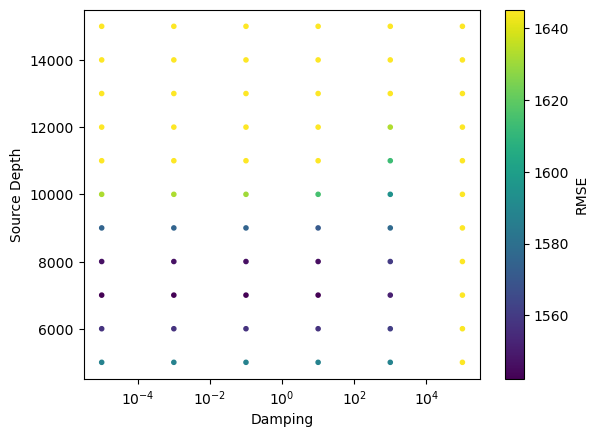

In [27]:
plt.figure()
plt.scatter(
    damping,
    source_depth,
    c=scores,
    cmap="viridis",
    marker='.',
    vmax= np.percentile(scores,50),
)
plt.xlabel('Damping')
plt.ylabel('Source Depth')
plt.xscale('log')
plt.colorbar(label='RMSE')
plt.show()

### Find optimal window size

### Shallow Prediction

In [28]:
# df = pd.DataFrame(np.transpose(coordinates[:2]), columns=['x', 'y'])
# shallow_block_coords, labels = vd.block_split(coordinates, spacing=5e4)
# block_point_size = df['x'].groupby(by=labels).count()
# eqs_depth = []
# constant = 2e8
# for i in labels:
#     eqs_depth.append(parameter_sets_shallow_eqs[best_shallow]['depth'] + (constant * 1/block_point_size[i]))
# plt.figure(figsize=(15,5))
# plt.subplot(1,2,1)
# plt.scatter(*coordinates[:2], c=labels, cmap='tab20c', s=0.001,)# vmin=np.min(eqs_depth), vmax=np.max(eqs_depth))
# plt.colorbar()
# plt.subplot(1,2,2)
# scale = np.percentile(eqs_depth, 99)
# plt.scatter(*coordinates[:2], c=eqs_depth, cmap='Greens', s=0.001, vmin=np.min(eqs_depth), vmax=scale)
# plt.colorbar()
# plt.show()

In [29]:
%%time
eqs_shallow = eqs.EquivalentSourcesMagneticGB(
    random_state=0,
    block_size=grid_spacing,
    window_size=window_size,
    damping=parameter_sets_shallow_eqs[best_shallow]['damping'],
    depth=parameter_sets_shallow_eqs[best_shallow]['depth'],
    repeat=2,
)
eqs_shallow.fit(coordinates, tfa_residuals, field_direction)

CPU times: user 1min 40s, sys: 26.8 s, total: 2min 7s
Wall time: 8.88 s


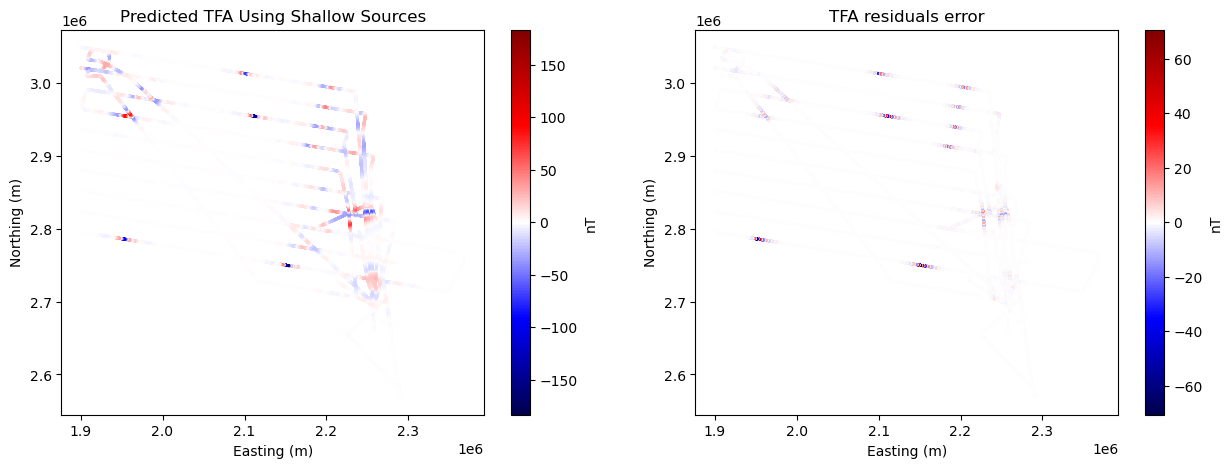

In [30]:
tfa_residuals_prediction = eqs.total_field_anomaly(eqs_shallow.predict(coordinates), field_direction)

plt.figure(figsize=(15,5))
scale = vd.maxabs(tfa_residuals_prediction)
plt.subplot(1,2,1)
plt.scatter(*coordinates[:2], c=tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("Predicted TFA Using Shallow Sources")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,2,2)
scale = vd.maxabs(tfa_residuals - tfa_residuals_prediction)
plt.scatter(*coordinates[:2], c=tfa_residuals - tfa_residuals_prediction, cmap="seismic", s=1, vmin=-scale, vmax=scale)
plt.title("TFA residuals error")
plt.xlabel( "Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.show()

## Predict on a regular grid

In [31]:
predicted_b = eqs_deep.predict(grid_coords_masked) + eqs_shallow.predict(grid_coords_masked)
predicted_tfa = eqs.total_field_anomaly(predicted_b, field_direction)
error_tfa = true_tfa - predicted_tfa
rmse_tfa = np.sqrt(np.nanmean((error_tfa)**2))

predicted_bnorm = np.sqrt(sum(c**2 for c in predicted_b))
error_bnorm = true_bnorm - predicted_bnorm
rmse_bnorm = np.sqrt(np.nanmean((error_tfa)**2))

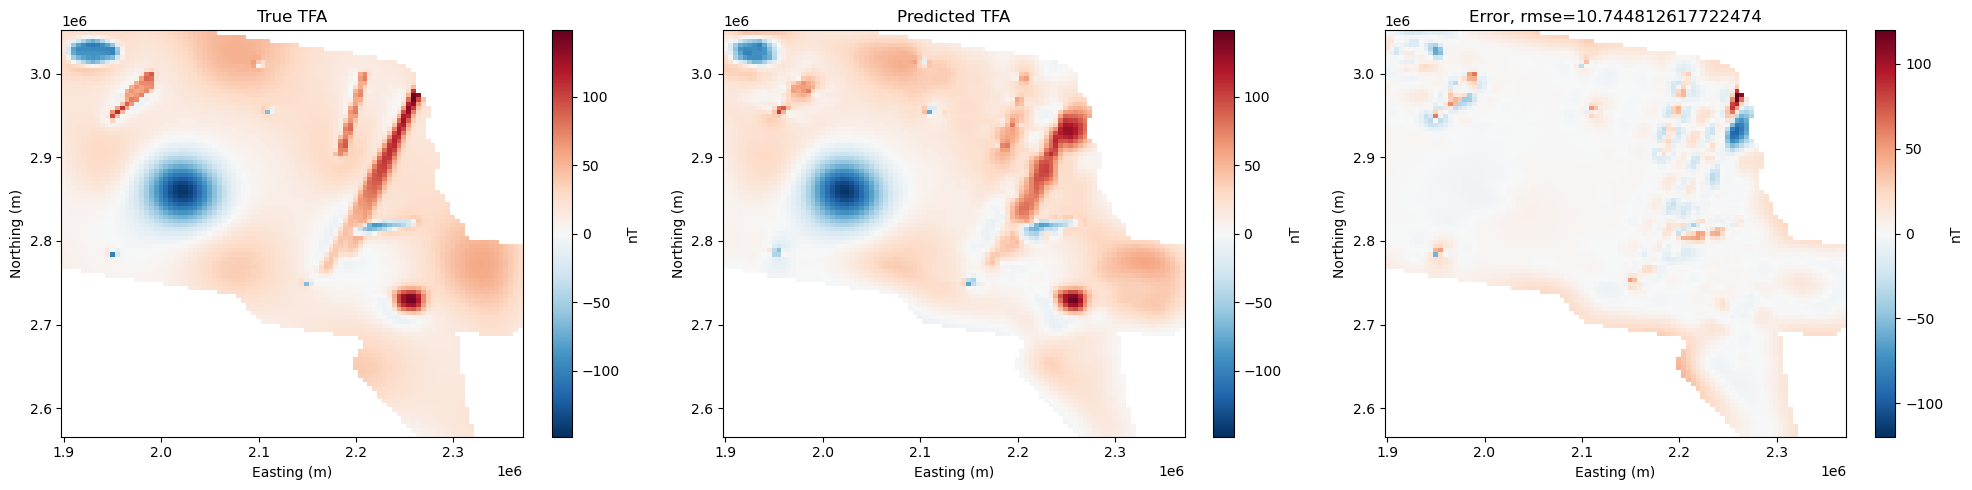

In [32]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_tfa)
plt.pcolormesh(*grid_coordinates[:2], true_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("True TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
#scale = np.nanpercentile(predicted_tfa, 99)
plt.pcolormesh(*grid_coordinates[:2], predicted_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
plt.title("Predicted TFA")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
scale = vd.maxabs(error_tfa)
plt.pcolormesh(*grid_coordinates[:2], error_tfa, cmap="RdBu_r", vmin=-scale, vmax=scale)
# plt.plot(*coordinates[:2], ".", color="#79BD9A", markersize=0.004, label='deep sources')
plt.title('Error, rmse={}'.format(rmse_tfa))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()

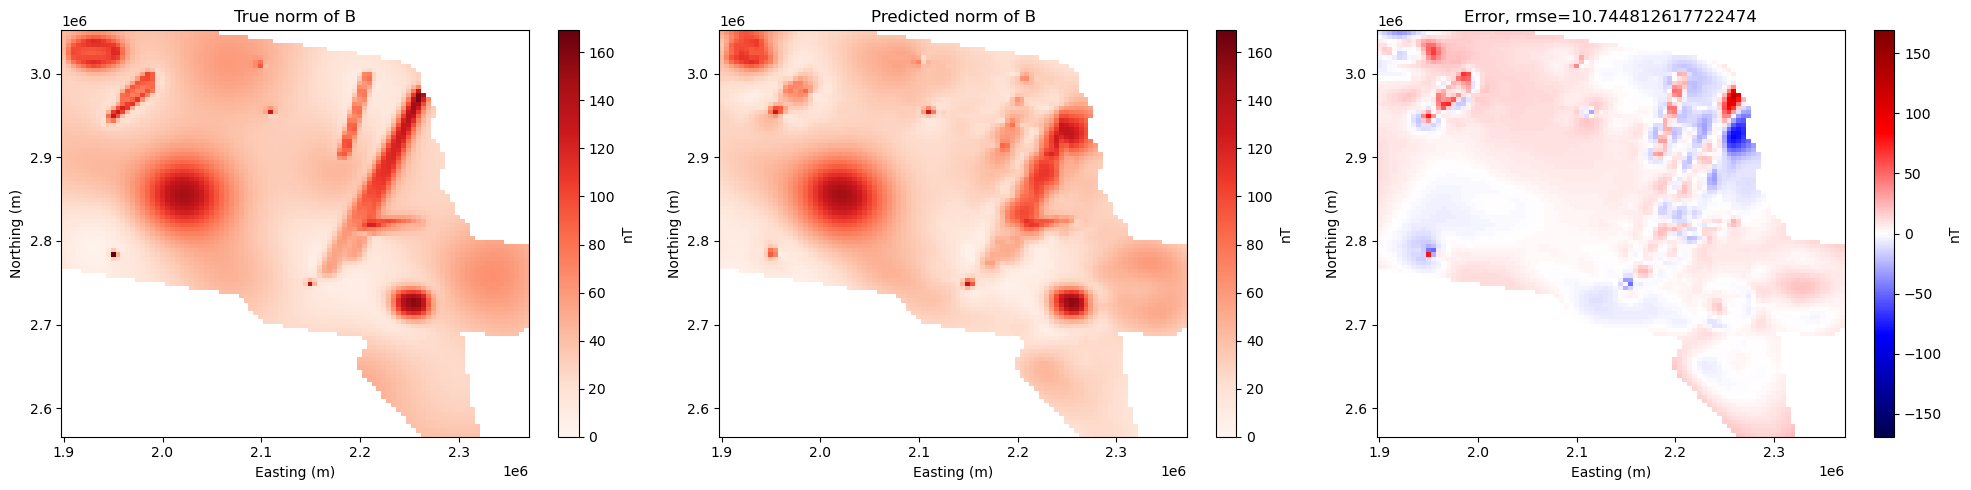

In [33]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
scale = vd.maxabs(true_bnorm)
plt.pcolormesh(*grid_coordinates[:2], true_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("True norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,2)
#scale = vd.maxabs(predicted_bnorm)
plt.pcolormesh(*grid_coordinates[:2], predicted_bnorm, cmap="Reds", vmin=0, vmax=scale)
plt.title("Predicted norm of B")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")

plt.subplot(1,3,3)
#scale = vd.maxabs(error_bnorm)
plt.pcolormesh(*grid_coordinates[:2], error_bnorm, cmap="seismic", vmin=-scale, vmax=scale)
#plt.plot(*coordinates[:2], ".", color="#79BD9A", markersize=0.004, label='deep sources')
plt.title('Error, rmse={}'.format(rmse_bnorm))
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.colorbar(label="nT")
plt.tight_layout()
plt.show()